In [9]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# data renaming for conveniency
import os
import shutil

def rename_image_mask_pairs(root_dir):
    image_dir = os.path.join(root_dir, "image")
    mask_dir = os.path.join(root_dir, "mask_blend")

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    image_basenames = {os.path.splitext(f)[0]: f for f in image_files}
    mask_basenames = {os.path.splitext(f)[0]: f for f in mask_files}

    matched_keys = sorted(set(image_basenames) & set(mask_basenames))

    print(f"Найдено совпадающих пар: {len(matched_keys)}")

    for idx, key in enumerate(matched_keys):
        new_name = f"{idx:04d}.png"

        old_image = os.path.join(image_dir, image_basenames[key])
        old_mask = os.path.join(mask_dir, mask_basenames[key])

        new_image = os.path.join(image_dir, new_name)
        new_mask = os.path.join(mask_dir, new_name)

        shutil.move(old_image, new_image)
        shutil.move(old_mask, new_mask)

        print(f"✅ {image_basenames[key]} + {mask_basenames[key]} → {new_name}")



In [64]:
# run renaming
rename_image_mask_pairs(r"D:\Paper_1\renders\render_icesat2")


🔍 Найдено совпадающих пар: 1400
✅ 0000.png + 0000.png → 0000.png
✅ 0001.png + 0001.png → 0001.png
✅ 0002.png + 0002.png → 0002.png
✅ 0003.png + 0003.png → 0003.png
✅ 0004.png + 0004.png → 0004.png
✅ 0005.png + 0005.png → 0005.png
✅ 0006.png + 0006.png → 0006.png
✅ 0007.png + 0007.png → 0007.png
✅ 0008.png + 0008.png → 0008.png
✅ 0009.png + 0009.png → 0009.png
✅ 0010.png + 0010.png → 0010.png
✅ 0011.png + 0011.png → 0011.png
✅ 0012.png + 0012.png → 0012.png
✅ 0013.png + 0013.png → 0013.png
✅ 0014.png + 0014.png → 0014.png
✅ 0015.png + 0015.png → 0015.png
✅ 0016.png + 0016.png → 0016.png
✅ 0017.png + 0017.png → 0017.png
✅ 0018.png + 0018.png → 0018.png
✅ 0019.png + 0019.png → 0019.png
✅ 0020.png + 0020.png → 0020.png
✅ 0021.png + 0021.png → 0021.png
✅ 0022.png + 0022.png → 0022.png
✅ 0023.png + 0023.png → 0023.png
✅ 0024.png + 0024.png → 0024.png
✅ 0025.png + 0025.png → 0025.png
✅ 0026.png + 0026.png → 0026.png
✅ 0027.png + 0027.png → 0027.png
✅ 0028.png + 0028.png → 0028.png
✅ 0029.png 

In [ ]:
# detection boxes & segmentation masks creation
import cv2
import numpy as np
import os
from tqdm import tqdm

# classes by pixel values
pixel_to_class = {
    255: 0,   # solar panel
    127: 1,   # base
     51: 2    # payload
}

def generate_yolo_segmentation_annotation(mask, output_txt_path, pixel_to_class_map):
    h, w = mask.shape
    lines = []

    for pixel_val, class_id in pixel_to_class_map.items():
        binary = (mask == pixel_val).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            if len(cnt) < 3:
                continue
            coords = []
            for point in cnt:
                x, y = point[0]
                coords.append(x / w)
                coords.append(y / h)
            line = f"{class_id} " + " ".join(f"{v:.6f}" for v in coords)
            lines.append(line)

    with open(output_txt_path, "w") as f:
        f.write("\n".join(lines))

def process_starlink_mask(mask_path, bbox_output_dir, seg_output_dir, image_name="Image0000", satellite_class_id=0):
    os.makedirs(bbox_output_dir, exist_ok=True)
    os.makedirs(seg_output_dir, exist_ok=True)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Не удалось прочитать маску: {mask_path}")
    if not np.any(mask > 0):
        print(f"Пустая маска: {mask_path}")
        return

    h, w = mask.shape

    nonzero = cv2.findNonZero((mask > 0).astype(np.uint8))
    x, y, bw, bh = cv2.boundingRect(nonzero)

    x_center = (x + bw / 2) / w
    y_center = (y + bh / 2) / h
    norm_w = bw / w
    norm_h = bh / h

    bbox_txt_path = os.path.join(bbox_output_dir, f"{image_name}.txt")
    yolo_line = f"{satellite_class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}"
    with open(bbox_txt_path, "w") as f:
        f.write(yolo_line + "\n")

    seg_txt_path = os.path.join(seg_output_dir, f"{image_name}.txt")
    generate_yolo_segmentation_annotation(mask, seg_txt_path, pixel_to_class)

def batch_process_masks(input_dir, bbox_output_dir, seg_output_dir, satellite_class_id=0):
    os.makedirs(bbox_output_dir, exist_ok=True)
    os.makedirs(seg_output_dir, exist_ok=True)

    files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(".png")])

    for idx, filename in enumerate(tqdm(files, desc="Processing masks")):
        input_path = os.path.join(input_dir, filename)
        image_name = f"{idx:04d}"
        try:
            process_starlink_mask(
                mask_path=input_path,
                bbox_output_dir=bbox_output_dir,
                seg_output_dir=seg_output_dir,
                image_name=image_name,
                satellite_class_id=satellite_class_id
            )
        except Exception as e:
            print(f"Ошибка в файле {filename}: {e}")


In [65]:
# run masks and boxes creation 
input_masks_dir = r"D:\Paper_1\renders\render_icesat2\mask_blend"
bbox_output_dir = r"D:\Paper_1\renders\render_icesat2\mask_det"
seg_output_dir = r"D:\Paper_1\renders\render_icesat2\mask_seg"

satellite_class_id = 5

batch_process_masks(
    input_dir=input_masks_dir,
    bbox_output_dir=bbox_output_dir,
    seg_output_dir=seg_output_dir,
    satellite_class_id=satellite_class_id
)


Processing masks: 100%|██████████| 1400/1400 [00:26<00:00, 53.27it/s]


In [ ]:
# visual testing
import random
import matplotlib.pyplot as plt

def visualize_yolo_segmentation_and_bbox(image_dir, seg_txt_dir, bbox_txt_dir, count=15):
    all_txt_files = [f for f in os.listdir(seg_txt_dir) if f.endswith('.txt')]
    selected = random.sample(all_txt_files, min(count, len(all_txt_files)))

    for fname in selected:
        base = fname.replace('.txt', '')
        img_path = os.path.join(image_dir, base + '.png')
        seg_txt_path = os.path.join(seg_txt_dir, base + '.txt')
        bbox_txt_path = os.path.join(bbox_txt_dir, base + '.txt')

        if not os.path.exists(img_path):
            print(f"Пропущено: нет изображения {img_path}")
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        vis_img = img.copy()

        if os.path.exists(bbox_txt_path):
            with open(bbox_txt_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    class_id, xc, yc, bw, bh = parts
                    x1 = int((xc - bw / 2) * w)
                    y1 = int((yc - bh / 2) * h)
                    x2 = int((xc + bw / 2) * w)
                    y2 = int((yc + bh / 2) * h)
                    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(vis_img, f"BBox {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        if os.path.exists(seg_txt_path):
            with open(seg_txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    coords = list(map(float, parts[1:]))
                    points = np.array([[int(coords[i]*w), int(coords[i+1]*h)] for i in range(0, len(coords), 2)], np.int32)
                    points = points.reshape((-1, 1, 2))
                    cv2.polylines(vis_img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
                    cv2.putText(vis_img, f"Seg {class_id}", tuple(points[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        plt.figure(figsize=(10, 6))
        plt.imshow(vis_img)
        plt.title(f"{base}")
        plt.axis('off')
        plt.show()


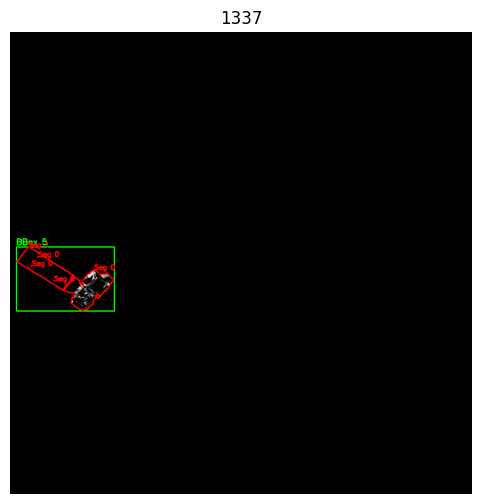

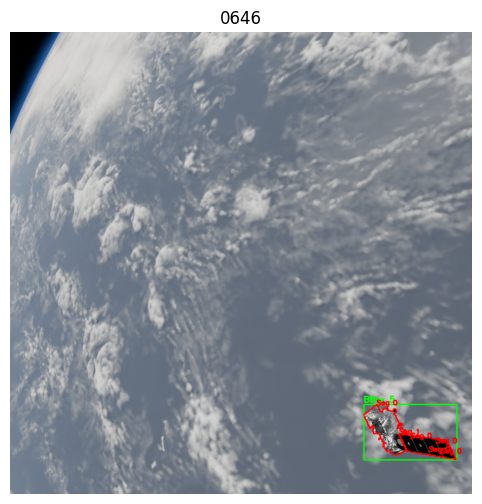

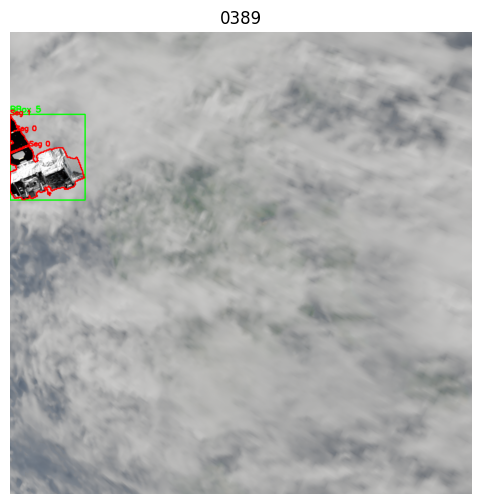

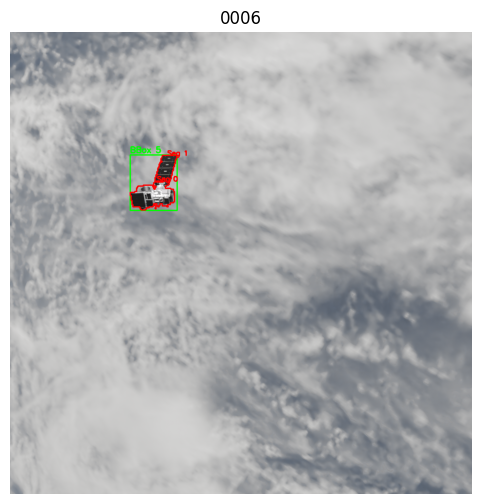

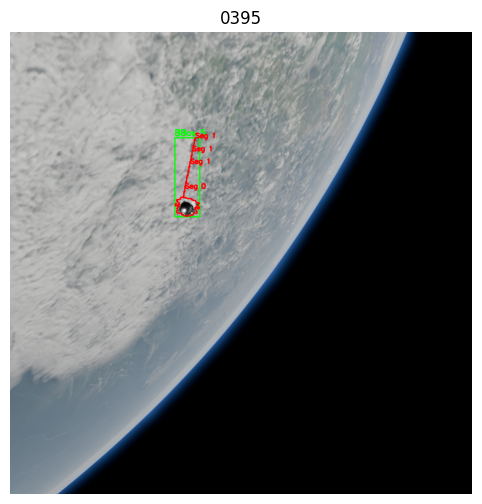

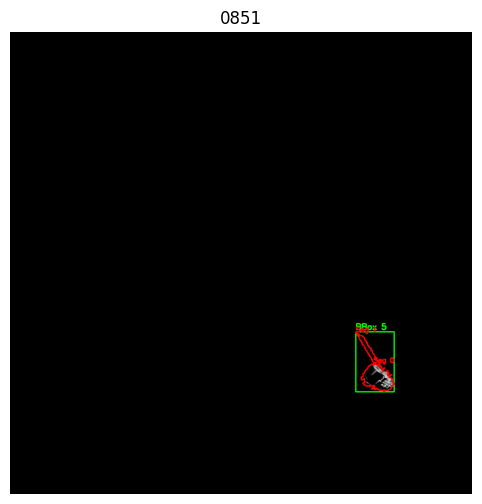

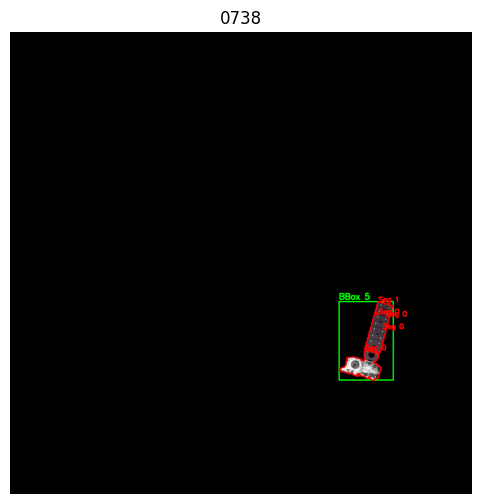

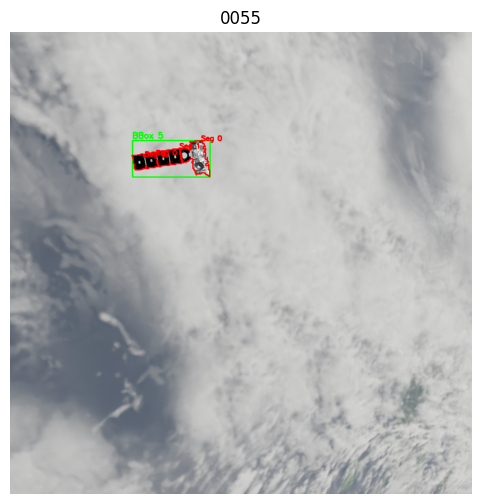

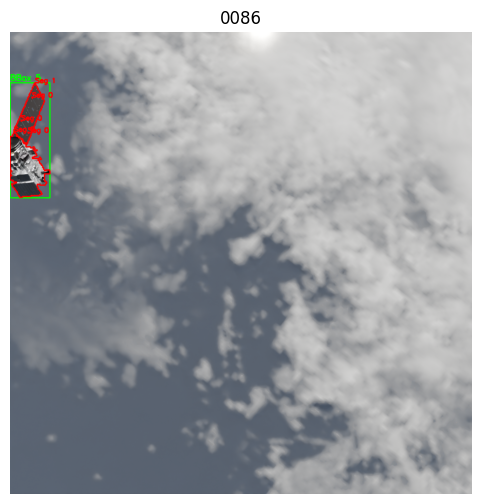

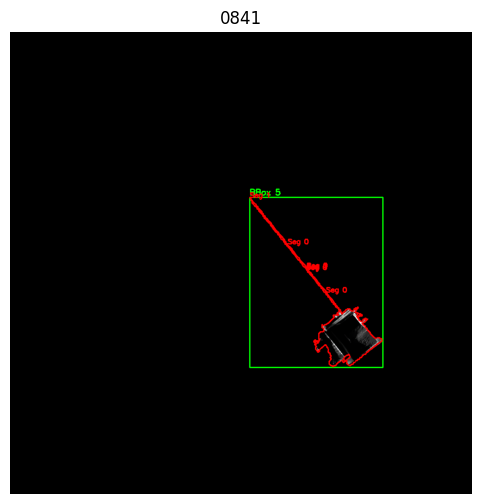

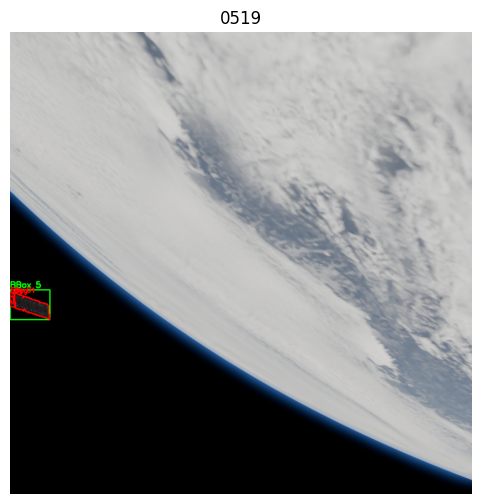

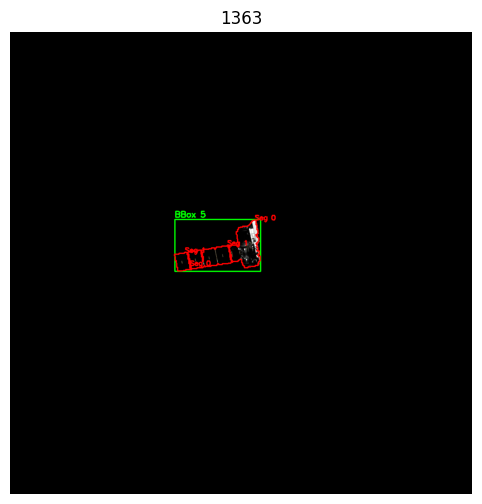

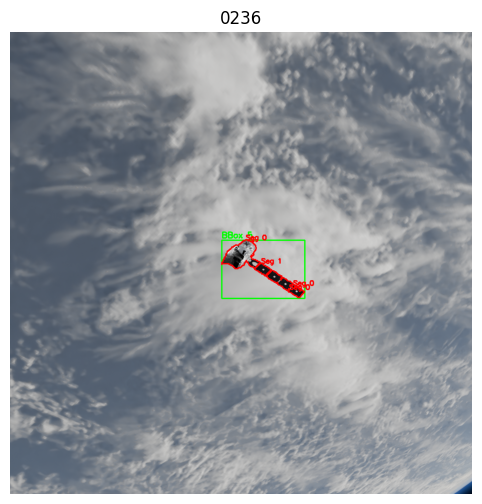

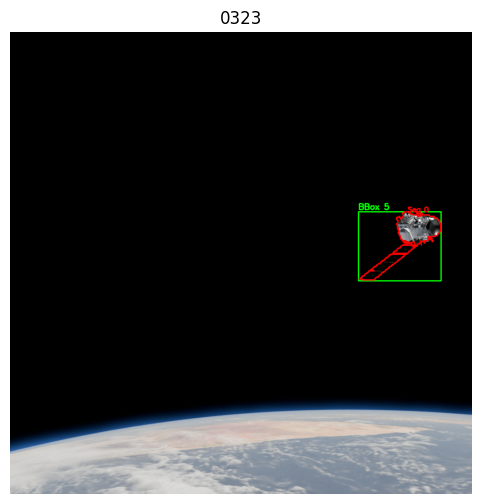

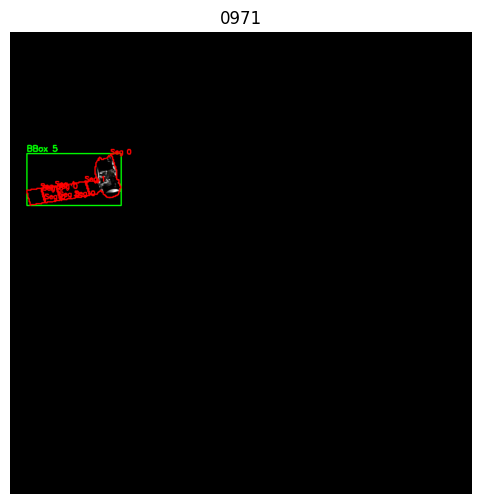

In [67]:
# run visual testing
visualize_yolo_segmentation_and_bbox(
    image_dir=r"D:\Paper_1\renders\render_icesat2\image",
    seg_txt_dir=r"D:\Paper_1\renders\render_icesat2\mask_seg",
    bbox_txt_dir=r"D:\Paper_1\renders\render_icesat2\mask_det",
    count=15
)
